In [ ]:
import os
import requests
from PIL import Image, UnidentifiedImageError
from io import BytesIO
from torch.utils.data import Dataset
import pandas as pd


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split

In [ ]:
import torch.nn as nn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
df = pd.read_csv('/content/drive/My Drive/deeplearning/final project/animedataset/anime-dataset-2023.csv')
df = df.head(1000) # DELETE, THIS IS JUST FOR TESTING MODEL
df = df[['English name', 'Genres', 'Image URL']]
df['Genres'] = df['Genres'].apply(lambda x: x.split(', '))  # Split genre strings into lists

# One-hot encode the genres
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(df['Genres'])
genre_labels = mlb.classes_
df['encoded_genres'] = list(genres_encoded)

In [ ]:
df_unlabeled = df[df['English name'] == 'UNKNOWN']
df_labeled = df[df['English name'] != 'UNKNOWN']

In [ ]:
train_df, val_df = train_test_split(df_labeled, test_size=0.2)

In [ ]:
num_genres = len(df_labeled['encoded_genres'][0])

## Custom Dataset to process and read image Data

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.dummy_image = torch.zeros(3, 224, 224)
        self.dummy_label = torch.zeros(num_genres)  # Adjust based on the number of genres

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_url = self.dataframe.iloc[idx]['Image URL']
        labels = self.dataframe.iloc[idx]['encoded_genres']
        labels = torch.tensor(labels, dtype=torch.float)
        try:
            response = requests.get(img_url)
            image = Image.open(BytesIO(response.content))

            # Convert grayscale images to RGB
            if image.mode != 'RGB':
                image = image.convert('RGB')

            if self.transform:
                image = self.transform(image)

            return image, labels

        except (UnidentifiedImageError, requests.exceptions.RequestException):
            # Return dummy image and label in case of an error
            return self.dummy_image, self.dummy_label

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Adjust size as per model requirement
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
from torch.utils.data import DataLoader

train_dataset = CustomDataset(train_df, transform=transform)
val_dataset = CustomDataset(val_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # Adjust batch size as needed
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

In [ ]:
from sklearn.metrics import hamming_loss
import numpy as np

def calculate_hamming_loss(y_true, y_pred, threshold=0.5):
    # Applying a threshold to the predictions
    y_pred = (y_pred > threshold).float()

    # Converting tensors to numpy arrays
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()

    return hamming_loss(y_true, y_pred)

## Training model based on transfer learning

In [ ]:
from copy import deepcopy
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_model_wts = deepcopy(model.state_dict())
    best_loss = 1.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            all_labels = []
            all_predictions = []

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device).float()

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

                # collect all labels
                all_labels.append(labels)
                all_predictions.append(outputs)

            all_labels = torch.cat(all_labels)
            all_predictions = torch.cat(all_predictions)
            epoch_hamming_loss = calculate_hamming_loss(all_labels, all_predictions)
            print(f'{phase} Hamming Loss: {epoch_hamming_loss:.4f} ')

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f}')

            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = deepcopy(model.state_dict())

        print()

    print('Training complete')
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_genres)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 109MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
from torch.optim import lr_scheduler
criterion = nn.BCEWithLogitsLoss() # used for multi label classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
trained_model = train_model(model, criterion, optimizer, scheduler, num_epochs=5)

Epoch 0/4
----------
train Hamming Loss: 0.1393 
train Loss: 0.3560
val Hamming Loss: 0.2219 
val Loss: 9.1788

Epoch 1/4
----------
train Hamming Loss: 0.1383 
train Loss: 0.3059
val Hamming Loss: 0.1458 
val Loss: 0.3177

Epoch 2/4
----------
train Hamming Loss: 0.1286 
train Loss: 0.2877
val Hamming Loss: 0.1442 
val Loss: 0.3546

Epoch 3/4
----------
train Hamming Loss: 0.1239 
train Loss: 0.2729
val Hamming Loss: 0.1379 
val Loss: 0.3107

Epoch 4/4
----------
train Hamming Loss: 0.1195 
train Loss: 0.2653
val Hamming Loss: 0.1420 
val Loss: 0.2994

Training complete


## Supervised Learning

In [ ]:
confidence_threshold = 0.7

# Predict genres for the unlabeled data
unlabeled_loader = DataLoader(CustomDataset(df_unlabeled, transform=transform), batch_size=32, shuffle=False)
model.eval()
all_predictions = []

for inputs, _ in unlabeled_loader:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = inputs.to(device)
    with torch.no_grad():
        outputs = model(inputs)
    all_predictions.append(outputs.sigmoid())  # convert to probabilities

# thresholding and assigning labels
all_predictions = torch.cat(all_predictions)
pseudo_labels = (all_predictions > confidence_threshold).int()

In [ ]:
pseudo_labels

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 1, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.int32)

In [ ]:
# creating a new dataframe with pseudo labels + combining with original training data
pseudo_labeled_df = df_unlabeled.copy()
pseudo_labeled_df['encoded_genres'] = pseudo_labels.tolist()
extended_train_df = pd.concat([train_df, pseudo_labeled_df])
extended_train_df, extended_val_df = train_test_split(extended_train_df, test_size=0.2)
extended_train_dataset = CustomDataset(extended_train_df, transform=transform)
extended_val_dataset = CustomDataset(extended_val_df, transform=transform)

extended_train_loader = DataLoader(extended_train_dataset, batch_size=32, shuffle=True)
extended_val_loader = DataLoader(extended_val_dataset, batch_size=32, shuffle=False)

dataloaders = {'train': extended_train_loader, 'val': extended_val_loader}
dataset_sizes = {'train': len(extended_train_dataset), 'val': len(extended_val_dataset)}

In [ ]:
retrained_model = train_model(model, criterion, optimizer, scheduler, num_epochs=5)

Epoch 0/4
----------
train Hamming Loss: 0.0734 
train Loss: 0.1812
val Hamming Loss: 0.0625 
val Loss: 0.1550

Epoch 1/4
----------
train Hamming Loss: 0.0720 
train Loss: 0.1627
val Hamming Loss: 0.0614 
val Loss: 0.1523

Epoch 2/4
----------
train Hamming Loss: 0.0593 
train Loss: 0.1473
val Hamming Loss: 0.0601 
val Loss: 0.1490

Epoch 3/4
----------
train Hamming Loss: 0.0542 
train Loss: 0.1325
val Hamming Loss: 0.0601 
val Loss: 0.1524

Epoch 4/4
----------
train Hamming Loss: 0.0457 
train Loss: 0.1179
val Hamming Loss: 0.0603 
val Loss: 0.1494

Training complete


In [ ]:
import matplotlib.pyplot as plt

def display_sample_and_predict_genres(model, dataset, index, mlb, threshold=0.5):
    model.eval()
    device = next(model.parameters()).device
    sample_image, actual_labels = dataset[index]
    image = sample_image.to(device).unsqueeze(0)

    # Predict genres
    with torch.no_grad():
        outputs = model(image)
        probabilities = torch.sigmoid(outputs)
        predicted_probabilities = probabilities.squeeze(0).cpu()

    predicted_labels = (predicted_probabilities > threshold).int()
    predicted_genres = [mlb.classes_[i] for i, label in enumerate(predicted_labels) if label == 1]

    def display_image(image_tensor):
        image = image_tensor.permute(1, 2, 0)
        image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Unnormalize
        image = image.clip(0, 1)
        plt.imshow(image)
        plt.axis('off')
        plt.show()

    display_image(sample_image)

    # Print actual and predicted genres
    actual_genre_labels = mlb.inverse_transform(actual_labels.unsqueeze(0))[0]
    print("Actual Genres:", ', '.join(actual_genre_labels))
    print("Predicted Genres:", ', '.join(predicted_genres))


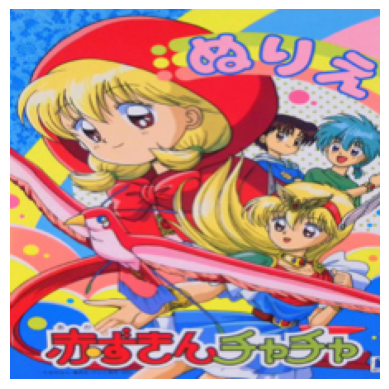

Actual Genres: Adventure, Comedy, Fantasy, Romance
Predicted Genres: Comedy


In [ ]:
display_sample_and_predict_genres(retrained_model, val_dataset, 2, mlb)